## Detecting Diabetic Retinopathy With Deep Learning

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

Previous efforts have made good progress using image classification, pattern recognition, and machine learning. With photos of eyes as input, the goal of this project is to use transfer learning to create a model, that can be used to accurately detect the presence of diabetic retinopathy in eyes




In [1]:
# Importing the relevant packages  

import numpy as np
import pandas as pd
import os
from PIL import Image,ImageOps
import cv2
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import copy
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
# Import torch packages

import torch
from torch import nn,optim
from torchvision import transforms,models
from torchvision.transforms import ToTensor
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
# Importing sklearn packages
from skll import kappa

## Exploratary Data Analysis

The distribution of classes in the dataset are as follows


                Value counts  Percentage
Normal                 25810   73.478335
Moderate NPDR           5292   15.065763
Mild NPDR               2443    6.954962
Severe NPDR              873    2.485338
Proliferate DR           708    2.015601




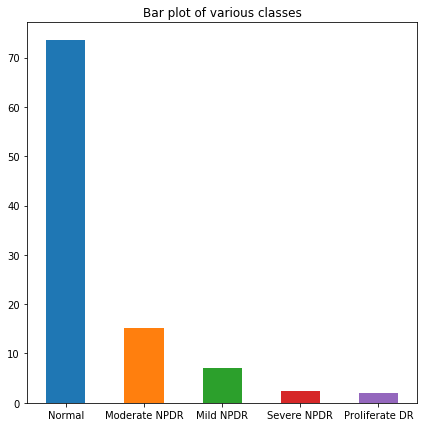

In [10]:
labels = pd.read_csv('projects/trainLabels.csv',encoding = 'UTF-8',engine='python')
labels.set_index("image", inplace=True)

print('The distribution of classes in the dataset are as follows')
print('\n')
Label_names = {0:'Normal',1:'Mild NPDR',2:'Moderate NPDR',3:'Severe NPDR',4:'Proliferate DR'}
labels['level'] = labels['level'].map(Label_names)

# percentage in each class
percentage = labels['level'].value_counts(normalize=True) * 100

# data points in each class
count_classes = labels['level'].value_counts()

print(pd.concat([count_classes, percentage], axis=1,keys=['Value counts','Percentage']))
print('\n')

percentage.plot(kind='bar',title='Bar plot of various classes',rot='horizontal',figsize=((7,7)))

The height of the image is : 2592
The width of the image is : 3888
The image has 3 color channels


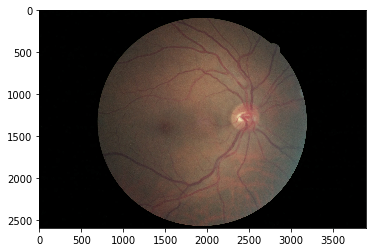

In [17]:
# Visualizing a sample image

test_image2 = mpimg.imread(r'projects/Train/train/19_right.jpeg')
plt.imshow(test_image2)
print('The height of the image is : {}'.format(test_image2.shape[0]))
print('The width of the image is : {}'.format(test_image2.shape[1]))
print('The image has {} color channels'.format(test_image2.shape[2]))

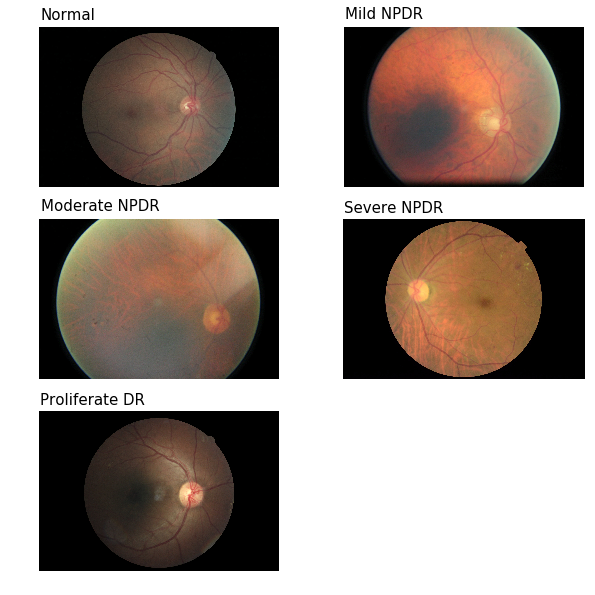

In [5]:
# Visualizing images from each class. The images were obtained after manually checking the dataset

ext = '.jpeg'
par_dir = 'projects/Train/train/'

image_names = [par_dir+'19_right'+ext,par_dir+'214_left'+ext,
               par_dir+'219_left'+ext,par_dir+'2275_left'+ext,
               par_dir+'2031_right'+ext]

plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(len(image_names)):
    image = mpimg.imread(image_names[i])
    plt.subplot(3,2,i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.text(15,-125,'{}'.format(Label_names[i]),fontsize=15)

It can be observed that there is class imbalance in the dataset. 3 techniques are tried to combat this below:

(1) Oversampling minority data 

(2) Cost sensitive classification

(3) Data augmentation of only the minority data

## Preprocessing Pipeline


Nearly all the images are taken of different people, using different cameras, and of different sizes.This data is extremely noisy, and requires multiple preprocessing steps to get all images to a format appropriate for training a model.

The preprocessing pipeline consists of five steps. Please refer Preprocessing.py to view them.

(1) scaling the radius of the eye,

(2) cropping and resizing,

(3) removing high frequency noise,

(4) image blending,

(5) contrast limited adaptive histogram equalization

In [23]:
# automatically reload if any changes are made to the .py file
%load_ext autoreload
%autoreload 2

# the entire preprocessing pipeline
import Preprocessing 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# the entire preprocessing pipeline

Preprocessing.preprocessing_pipeline()

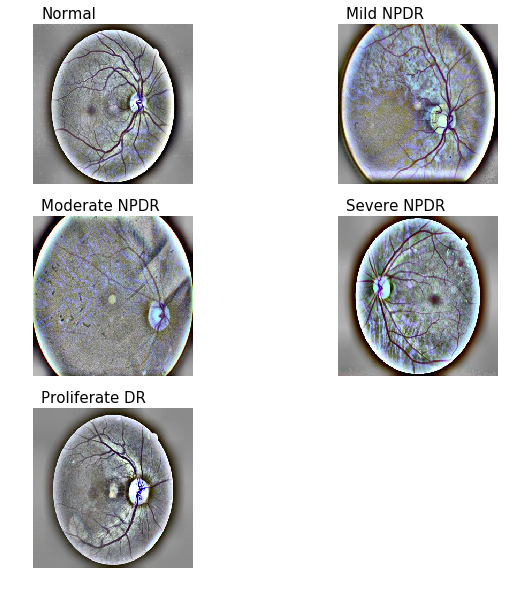

In [10]:
# Visulazing the same images as above after preprocessing

ext = '.jpeg'
par_dir = 'projects/Processed_images/'

image_names = [par_dir+'19_right'+ext,par_dir+'214_left'+ext,
               par_dir+'219_left'+ext,par_dir+'2275_left'+ext,
               par_dir+'2031_right'+ext]

plt.figure(figsize=(10,10))

for i in range(len(image_names)):
    image = mpimg.imread(image_names[i])
    plt.subplot(3,2,i+1)
    plt.axis('off')
    plt.imshow(image)
    plt.text(15,-10,'{}'.format(Label_names[i]),fontsize=15)

## Preparing the data

In [13]:
## Loading the DataLoader

from data_loader import DiabeticRetinopathyDataset

In [14]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees = [0,270]),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
        
# Create the train and validation datasets augmentation only on train dataset

train_dataset = DiabeticRetinopathyDataset(csv_file = 'projects/trainLabels.csv',
                                              root_dir = 'projects/Images/Processed_images/',
                                              transform = train_transforms)

validation_dataset = DiabeticRetinopathyDataset(csv_file = 'projects/trainLabels.csv',
                                              root_dir = 'projects/Images/Processed_images/',
                                              transform = valid_transforms)

## Creating the train loader and validation loader

In [15]:
from Sampler import ImbalancedDatasetSampler

In [27]:
def Val_and_train_loader(train_set,validation_set,per_of_val=0.1,batch_train=64,batch_val=32):
    """
    Parameters:
        per_of_val : split for validation data
    
    return: 
        trainloader and validation loader
    """
    
    dataset_length = len(train_set)
    indices = list(range(dataset_length))
    split = int(per_of_val * dataset_length)
    
    valid_idx = np.random.choice(indices,size=split,replace=False)
    train_idx = list(set(indices) - set(valid_idx))
   
    train_dataset = torch.utils.data.Subset(train_set,train_idx)
    
    validation_sampler = SubsetRandomSampler(valid_idx)
    train_sampler = ImbalancedDatasetSampler(train_dataset)
                            
    train_loader = DataLoader(train_dataset, batch_size = batch_train,sampler = train_sampler)
    validation_loader = DataLoader(validation_set,batch_size=batch_val,sampler=validation_sampler)
    
    return train_loader,validation_loader

In [28]:
train_loader,validation_loader = Val_and_train_loader(train_dataset,validation_dataset)

## Defining the Model- Transfer Learning

In [46]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    

In [47]:
from collections import OrderedDict

# adapted from fast ai

fc  = nn.Sequential(OrderedDict([
                                ('batchnorm1',nn.BatchNorm1d(2048,eps=1e-05,momentum=0.1,affine=True)),
                                ('dropout1',nn.Dropout(p=0.5)),
                                ('fc1',nn.Linear(2048,512,bias=True)),
                                ('batchnorm2',nn.BatchNorm1d(512,eps=1e-05,momentum=0.1,affine=True)),
                                ('relu',nn.ReLU()),
                                ('dropout2',nn.Dropout(p=0.6)),
                                ('fc2',nn.Linear(512,5,bias=True)),
                                ('output',nn.LogSoftmax(dim=1))
                                ]))

AdaptiveConcatPool2d = nn.Sequential(OrderedDict([
                                                 ('ap',nn.AdaptiveAvgPool2d(output_size=(1,1))),
                                                 ('mp',nn.AdaptiveMaxPool2d(output_size=(1,1)))]))       

model.avgpool = AdaptiveConcatPool2d
model.fc = fc

In [48]:
# architecture after changing the last layer
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Loss function and optimizer

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [50]:
# loss function crossentropyloss for classification problem

criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.fc.parameters(),lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Functions for validation stats

In [51]:
# The validation procedure

def validation_stats(criterion,model,dataloader,device):
    """
    Parameters:
        model : the model
        dataloader : the validation loader
        device : cuda or cpu
        criterion : the loss function
    
    return: 
        cumulative loss and kappa score
    """
    
    cum_val_loss = 0
    
    all_true_labels = []
    all_predictions = []
    
    for images,labels in dataloader:
        images,labels = images.to(device),labels.to(device)
        
        output = model.forward(images)
        val_loss = criterion(output,labels)
        cum_val_loss +=val_loss.item()
        
        values = torch.exp(output)
        val_equal = values.max(dim=1)[1]
        
        all_true_labels.extend(list(labels.cpu().numpy()))
        all_predictions.extend(list(val_equal.cpu().numpy()))
        
    kappa_score = kappa(all_true_labels,all_predictions,weights='quadratic')
    
    return cum_val_loss,kappa_score

## Training the Network

In [52]:
def training(n_epochs,criterion,model,device,scheduler):
    
    best_model_wts = copy.deepcopy(model.state_dict())
   
    for epoch in tqdm(range(n_epochs)):
        
        running_loss = 0
        model.train()
        
        scheduler.step()
        
        for images,labels in train_loader:
    
            images,labels = images.to(device),labels.to(device)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output,labels)
        
            loss.backward()
            optimizer.step()
            
            running_loss +=loss.item()
            
        model.eval()
        with torch.no_grad():
            val_loss,kappa_score = validation_stats(criterion,model,validation_loader,device)

        print('Epoch {}/{}'.format(epoch+1,n_epochs),
              '| Training loss =  {:0.3f}'.format(running_loss / len(train_loader)),
              '| Validation_loss =  {:0.3f}'.format(val_loss / len(validation_loader)),
              '| Kappa_score {:0.3f}'.format(kappa_score))
        
        running_loss = 0
        model.train()
        
        state = {
                    'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
        torch.save(state, 'model_checkpoint.pth')
    
    return model
        
        

In [53]:
# Training the networks
num_epochs = 25
final_model = training(num_epochs,criterion,model,device,exp_lr_scheduler )

Epoch 1/25 | Training loss =  1.307 | Validation_loss =  1.382 | Kappa_score 0.262
Epoch 2/25 | Training loss =  1.251 | Validation_loss =  1.406 | Kappa_score 0.246
Epoch 3/25 | Training loss =  1.232 | Validation_loss =  1.308 | Kappa_score 0.298
Epoch 4/25 | Training loss =  1.222 | Validation_loss =  1.259 | Kappa_score 0.307
Epoch 5/25 | Training loss =  1.222 | Validation_loss =  1.288 | Kappa_score 0.309
Epoch 6/25 | Training loss =  1.205 | Validation_loss =  1.272 | Kappa_score 0.318
Epoch 7/25 | Training loss =  1.206 | Validation_loss =  1.288 | Kappa_score 0.319
Epoch 8/25 | Training loss =  1.186 | Validation_loss =  1.252 | Kappa_score 0.338
Epoch 9/25 | Training loss =  1.177 | Validation_loss =  1.246 | Kappa_score 0.335
Epoch 10/25 | Training loss =  1.180 | Validation_loss =  1.224 | Kappa_score 0.341
Epoch 11/25 | Training loss =  1.178 | Validation_loss =  1.259 | Kappa_score 0.327
Epoch 12/25 | Training loss =  1.171 | Validation_loss =  1.211 | Kappa_score 0.357
E

In [54]:
torch.save(final_model.state_dict(),'final_model_weights.pth')